Trabalho  - Usando LSTM para prever séries temporais

Nesse laboratório iremos demonstrar como uma LSTM pode ser usada para previsão em séries temporais. Utilizaremos uma rede neuronal LSTM bem simples para tratar um caso de uma série temporal de número de doenças pulmonares na inglaterra

In [1]:
# Importando bibliotecas
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D, Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
numpy.random.seed(7)

In [9]:
# Carrega apenas a coluna com o total de doentes por mês 
dataframe = pandas.read_csv('ldeaths.csv', usecols=[1], engine='python', skipfooter=3, sep = ',')
dataframe.head(3)

,value
0,3035
1,2552
2,2704


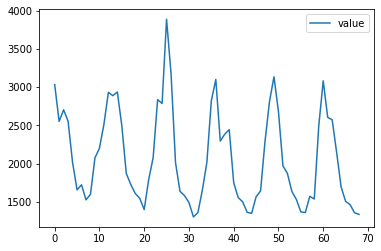

In [3]:
dataframe.plot()

Aqui tratamos os dados que vamos usar. Primeiro ajustamos a escala dos dados para ficarem entre 0 e 1. A seguir, dividimos os dados entre treino (67% primeiros meses) e testes (33% dos meses finais da série)

In [ ]:
#Converte a coluna do dataframe pandas em um vetor numpy
dataset = dataframe.values
dataset = dataset.astype('float32')

look_back = 12

# Divite os dados de treino (2/3) e teste (1/3)
# Note que a divisão não é aleatória, mas sim sequencial
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size-look_back-1:len(dataset),:]

Aqui criamos nossos pares de dados $X$ e $Y$, onde $Y_{t} = X_{t-1}$ (para look_bak=1). Uma outra forma de pensar no valor de $Y$ para um dado $X$ é que ele é o próximo $X$ na série temporal.

In [ ]:
# Recebe uma série e converte em uma matriz com séries deslocadas.
def create_dataset(dataset, look_back=1, std=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]-dataset[i, 0]
        a /= std
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]-dataset[i + look_back-1, 0])
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
std = train[:, 0].std()
trainX, trainY = create_dataset(train, look_back, std)
testX, testY = create_dataset(test, look_back, std)
# shape is [samples, time steps, features]

trainX = trainX.reshape(-1, look_back, 1)
testX = testX.reshape(-1, look_back, 1)
trainY = trainY / 30
testY = testY / 30

trainX.shape, testX.shape

((34, 12, 1), (24, 12, 1))

Agora criamos nossa rede LSTM com 32 recorrências (usa até 32 pontos da série para tentar prever o próximo número) e a treinamos.

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(look_back, 1), return_sequences=False)) # 16, 48
model.add(Dropout(0.2))
#model.add(LSTM(32, return_sequences=False)) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') #sgd
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=True),
    ModelCheckpoint('best.model', save_best_only=True),
    EarlyStopping(patience=25, verbose=True)
]

history = model.fit(trainX, trainY, epochs=5000, batch_size=24, validation_data=(testX, testY), #epochs
                    verbose=0, callbacks=callbacks)


Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00118: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 00123: early stopping


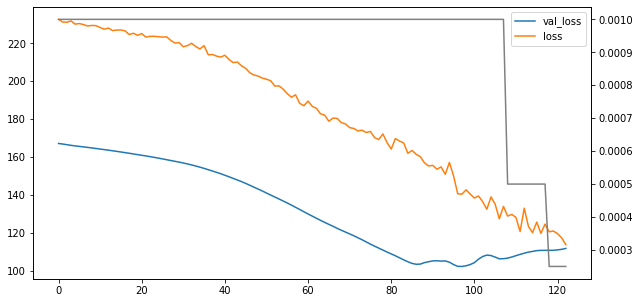

In [ ]:
df_history = pandas.DataFrame(history.history)
ax = df_history[['val_loss', 'loss']].plot(figsize=(10, 5))
df_history['lr'].plot(ax=ax.twinx(), color='gray')

In [ ]:
# Realiza as previsões. Notar que a utilidade de prever trainX é nenhuma. Serve apenas para exibir no gráfico.

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Ao final das previsões, reescalonamos os dados para a escala original e calculamos as métricas de RMSE.

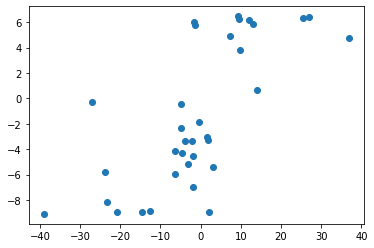

In [ ]:
plt.scatter(trainY, trainPredict.ravel())

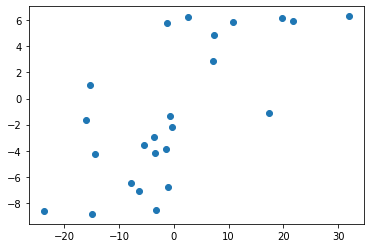

In [ ]:
plt.scatter(testY, testPredict.ravel())

In [ ]:
# Calcula os erros de previsão
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.00 RMSE
Test Score: 10.11 RMSE


Imprime o gráfico da previsão (em vermelho)

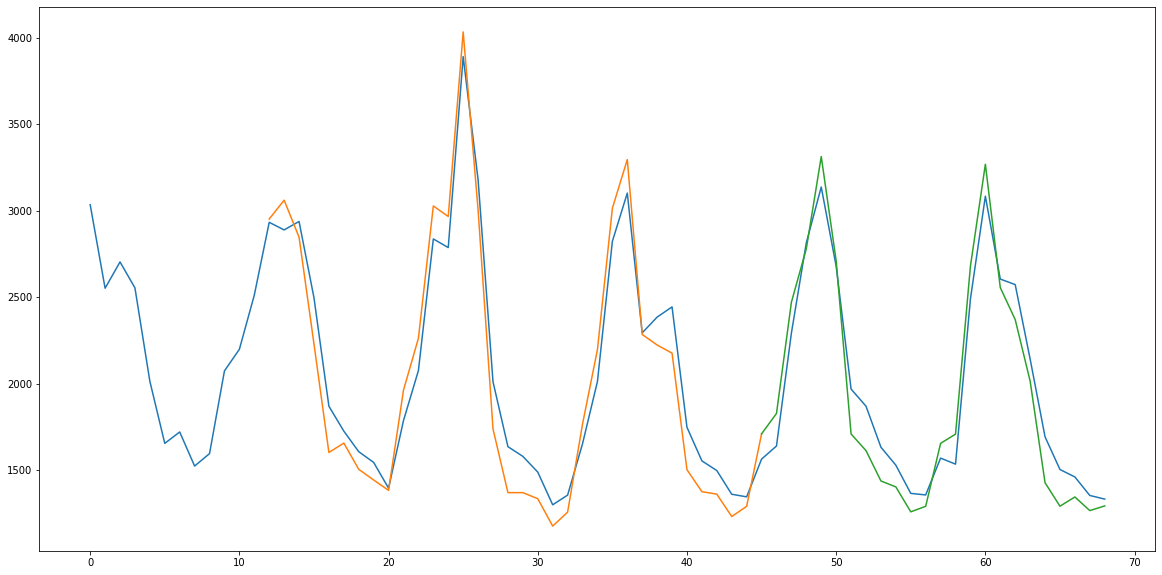

In [ ]:
# shift train predictions for plotting
trainPredictPlot = (trainPredict.ravel() * 30) + dataset[look_back:len(trainPredict)+look_back, 0]

# shift test predictions for plotting
testPredictPlot = (testPredict.ravel() * 30) + dataset[len(trainPredict)+(look_back)-1:len(dataset), 0]

# plot baseline and predictions
plt.figure(figsize=(20, 10))
plt.plot(dataset)
plt.plot(look_back+numpy.arange(len(trainPredictPlot)), trainPredictPlot)
plt.plot(look_back+numpy.arange(len(testPredictPlot))+len(trainPredictPlot)-1, testPredictPlot)
plt.show()

### Agora tente você melhorar o resultado do indicador RMSE